In [102]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.utils import data
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision import datasets
import torchvision.transforms as transforms
from PIL import Image, ImageDraw, ImageFilter, ImageTransform
import random as rand
import os
import torch.nn.functional as F
from PIL import Image
import numpy as np
import os
from copy import copy
import matplotlib

# Make torch dataset with YOLO labels
In our instance, YOLO has the following format:
output [x1,y1,w1,h1,C1,p11,p12,p13,p14,x2,y2,w2,h2,C2,p21,p22,p23,p24]

In [156]:
#utility functions for creating labels

PATH='/Users/ben/Downloads/archive'

def wide_or_tall(bbox):
    # wide or tall bbox
    x1 = bbox[0]
    y1 = bbox[1]
    x2 = bbox[2]
    y2 = bbox[3]
    if abs(x1-x2)>abs(y1-y2):
        return 'wide'
    else:
        return 'tall'

def probs(classname):
    #return C,p1,p2,p3,p4 subarr given object exists
    if classname==0.0:
        return [1,1,0,0,0]
    elif classname==1.0:
        return [1,0,1,0,0]
    elif classname==2.0:
        return [1,0,0,1,0]
    else:
        return [1,0,0,0,1]

# now we make our labels in [x1,y1,w1,h1,C1,p11,p12,p13,p14,x2,y2,w2,h2,C2,p21,p22,p23,p24] format
# say first bbox prediction wide, second bbox prediction tall

def make_labels(path):
    #read dataset labels into dictionary
    labels={}
    os.chdir(path)
    animals=['buffalo','elephant','rhino','zebra']
    for i,animal in enumerate(animals):
        for file in os.listdir(f'{path}/{animal}'):
            if '.txt' in file:
                classname = i
                f = open(f'{animal}/{file}')
                label = f.readlines()
                label = [l.replace('\n','') for l in label][0].split(' ')
                label = [float(l) for l in label]
                bbox = label[1:]
                bbox_type = wide_or_tall(bbox)
                #print(f"classname {classname} has bbox {bbox} type {bbox_type}")
                if bbox_type=='wide':
                    result_left = np.concatenate([bbox,probs(classname)])
                    result = np.concatenate([result_left,np.zeros([9,])])
                elif bbox_type=='tall':
                    result_right = np.concatenate([bbox,probs(classname)])
                    result = np.concatenate([np.zeros([9,]),result_right])
                labels[f'{animal}/{file}']=result
    return labels

labels = make_labels(PATH)
print(len(labels))

1504


In [159]:
# let's make our own torch dataset type...
# as we have custom labels
# inherits torch.utils.data.Dataset
class YOLODataset(Dataset):
    """YOLO dataset."""

    def __init__(self, path=PATH, transform=None):
        """
        Args:
            path: path to the dataset root folder, 
            default set by global var
        """
        self.path = path
        self.labels = make_labels(self.path)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        fname = list(self.labels.keys())[idx]
        
        label = self.labels[fname]
        img_name=f"{self.path}/{fname}"
        img_name=img_name.replace('.txt','.jpg')
        with Image.open(img_name) as im:
            sample = {'image': np.asarray(im), 'label': label}
        return sample
    
    def __showbbox__(self,idx):
        # return image with drawn bbox
        if torch.is_tensor(idx):
            idx = idx.tolist()
        res = self.__getitem__(idx)
        img = res['image']
        label = res['label']
        # wide bbox on left, tall on right
        widebbox = label[0:9]
        tallbbox = label[9:]
        if(widebbox.sum()!=0):
            print(widebbox)
        else:
            print(tallbbox)
    
ds = YOLODataset()
print(ds.__len__())
print(ds.__getitem__(200))
ds.__showbbox__(200)

1504
{'image': array([[[245, 246, 240],
        [244, 245, 240],
        [247, 247, 247],
        ...,
        [195, 197, 186],
        [235, 235, 233],
        [252, 251, 255]],

       [[255, 255, 250],
        [254, 255, 250],
        [254, 254, 254],
        ...,
        [206, 208, 197],
        [233, 233, 233],
        [230, 229, 234]],

       [[250, 251, 245],
        [247, 248, 243],
        [247, 247, 245],
        ...,
        [231, 232, 224],
        [246, 246, 246],
        [226, 225, 231]],

       ...,

       [[197, 183, 172],
        [212, 198, 187],
        [220, 206, 195],
        ...,
        [248, 239, 208],
        [238, 232, 200],
        [241, 235, 203]],

       [[167, 153, 142],
        [185, 171, 160],
        [197, 183, 172],
        ...,
        [247, 238, 207],
        [233, 227, 195],
        [242, 236, 204]],

       [[182, 168, 157],
        [200, 186, 175],
        [211, 197, 186],
        ...,
        [247, 238, 207],
        [227, 221, 189],
        [

In [7]:
# Get gpu device for training if available otherwise use cpu
device = "mps"
print(f"Using {device} device")

# darknet conv function adapted from Darknet53 implementation
# https://github.com/developer0hye/PyTorch-Darknet53/blob/master/model.py

def dark_conv(c_in, c_out, kernel=1, stride=1, padding=0):
    """
    Construct a convolutional block function 
    given the input dimensions
    c_in: channels in
    c_out: channels out
    kernel: filter / convolution size (is square)
    stride: convolution stride 
    padding: convolution padding 

    Based on DarkNet19 configuration
    """
    return nn.Sequential(
            nn.Conv2d(c_in, c_out, kernel, stride, padding),
            nn.BatchNorm2d(c_out),
            nn.Mish())

# Our CNN model
class DarkNet19(nn.Module):
    def __init__(self):
        super(DarkNet19, self).__init__()
        self.c1 = dark_conv(3, 32, 3)
        self.c2 = dark_conv(32, 64, 3)
        self.c3 = dark_conv(64, 128, 3)
        self.c4 = dark_conv(128, 64, 1)
        self.c5 = dark_conv(64, 128, 3)
        self.c6 = dark_conv(128, 256, 3)
        self.c7 = dark_conv(256, 128, 1)
        self.c8 = dark_conv(128, 256, 3)
        self.c9 = dark_conv(256, 512, 3)
        self.c10 = dark_conv(512, 256, 1)
        self.c11 = dark_conv(256, 512, 3)
        self.c12 = dark_conv(512, 256, 1)
        self.c13 = dark_conv(256, 512, 3)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        # output [x1,y1,w1,h1,C1,p11,p12,p13,p14,x2,y2,w2,h2,C2,p21,p22,p23,p24]
        self.fc = nn.Linear(512,18)

    def forward(self, x):
        # feature extraction
        x = self.c1(x)
        x = F.max_pool2d(x,2,2)
        x = self.c2(x)
        x = F.max_pool2d(x,2,2)
        x = self.c3(x)
        x = self.c4(x)
        x = self.c5(x)
        x = F.max_pool2d(x,2,2)
        x = self.c6(x)
        x = self.c7(x)
        x = self.c8(x)
        x = F.max_pool2d(x,2,2)
        x = self.c9(x)
        x = self.c10(x)
        x = self.c11(x)
        x = self.c12(x)
        x = self.c13(x)
        # head
        x = self.global_avg_pool(x)
        x = x.view(-1, 512)
        output = self.fc(x)
        return output

#declare CNN model instance
model = DarkNet19().to(device)
print("Neural Network PyTorch Architecture:")
print(model)

#define loss function and optimizer
#cross entropy loss
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

Using mps device
Neural Network PyTorch Architecture:
DarkNet19(
  (c1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Mish()
  )
  (c2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Mish()
  )
  (c3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Mish()
  )
  (c4): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Mish()
  )
  (c5): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Mi

In [8]:
def train(dataloader, model, loss_fn, optimizer):
    """
    Function to train CNN model
    """
    size = len(dataloader.dataset)
    model.train()
    history = []
    total_correct = 0
    total_done = 0
    count = 0
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        # Compute prediction error
        preds = model(x)
        loss = loss_fn(preds, y)

        # Backpropagation block
        # reset gradients to zero because by default we accumulate gradient 
        optimizer.zero_grad()
        # compute gradient of loss function using backprop
        loss.backward()
        # update parameters based on calculated gradient
        optimizer.step()

        # calculate accuracy 
        guesses = torch.argmax(preds, dim=1)
        correct = torch.sum(guesses==y).item()
        done = guesses.shape[0]
        total_correct += correct
        total_done += done

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(x)
            history.append(loss)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        count += 1

    #average accuracy over training set during training
    acc = total_correct / total_done
    return acc, history
    
def test_acc(dataloader, model, loss_fn):
    """
    Compute loss and accuracy of a model on some data
    """
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # we set model.eval() to turn off regularization stuff 
    # like dropout / batch norm
    model.eval()
    total_done = 0
    total_correct = 0
    test_loss = 0
    #don't store gradient when evaluating
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            # We compute this prediction loss
            loss = loss_fn(pred, y)
            guesses = torch.argmax(pred, dim=1)
            correct = torch.sum(guesses==y).item()
            done = guesses.shape[0]
            total_correct += correct
            total_done += done
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    acc = total_correct / total_done
    return acc, test_loss

Train and plot guesses

In [ ]:
"""
Train the model
Store training and validation loss and accuracy along the way
Interrupt when you see the validation accuracy plataeu 
We then load the best model weights (by validation accuracy)
and we can run inference with them
"""
#load best previous model
try:
    model = torch.load('best-model.pt')
except:
    print("No previous model.")

#train
best_val_acc = 0.0
epochs = 10
train_accs = []
train_losses = []
val_accs = []
val_losses = []
#initial val loss
val_acc, val_loss = test_acc(val_loader, model, loss_fn)
val_accs.append(val_acc)
val_losses.append(val_loss)
#initial training loss
train_acc, train_loss = test_acc(train_loader, model, loss_fn)
train_accs.append(train_acc)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    t_acc, t_loss = train(train_loader, model, loss_fn, optimizer)
    train_accs.append(t_acc)
    train_losses.append(t_loss)
    v_acc, v_loss = test_acc(val_loader, model, loss_fn)
    # save best model
    if v_acc > best_val_acc:
        # Method 1
        torch.save(model, 'best-model.pt') 
        best_val_acc = v_acc
    print("~"*40)
    print(f"Current val acc: {v_acc:.3f} best: {best_val_acc:.3f}")
    print("~"*40)
    val_accs.append(v_acc)
    val_losses.append(v_loss)
print("Done!")

In [ ]:
# save last model in case this works better than the "best one"
# (we may be overfitting to validation data by picking "best one" by val)
torch.save(model, 'last.pt')

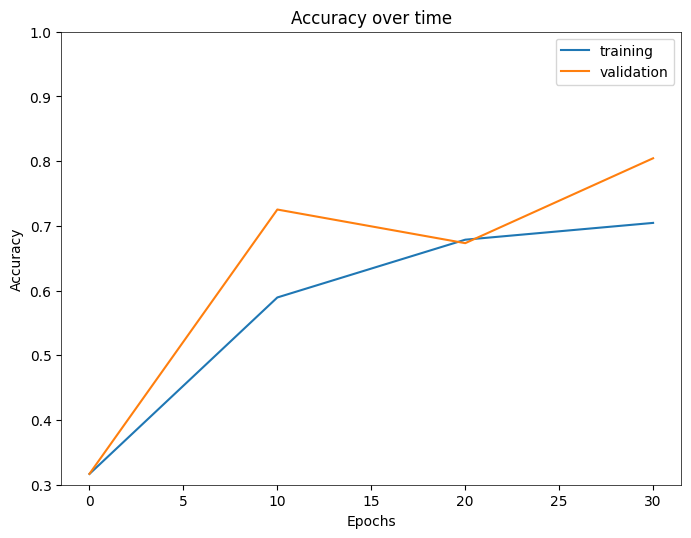

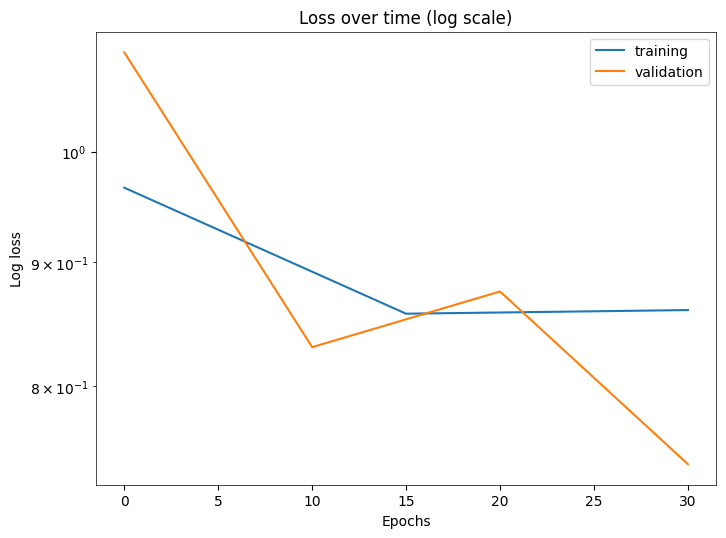

In [ ]:
# PLOT ACCURACIES
plt.rc('axes',edgecolor='black',linewidth=0.5)
train_accs = np.ravel(np.asarray(train_accs))
val_accs = np.reshape(val_accs,-1)

#x scaling to plot diff sized arrays on same plot
x_t = np.linspace(0, epochs, num=len(train_accs))
x_v = np.linspace(0, epochs, num=len(val_accs))

fig = plt.figure(figsize=(8, 6), dpi=100)
plt.plot(x_t, train_accs,label="training")
plt.plot(x_v, val_accs,label="validation")
plt.yscale("linear")
plt.title("Accuracy over time")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.savefig('acc.png')
plt.ylim([0.3,1])
plt.show()

# PLOT LOSS
t_losses_final = np.ravel(np.mean(train_losses,axis=1))
#t_losses_final = np.ravel(train_losses)
val_losses_final = np.ravel(val_losses)

#x scaling to plot diff sized arrays on same plot
x_t = np.linspace(0, epochs, len(t_losses_final))
x_v = np.linspace(0, epochs, len(val_losses_final))
fig = plt.figure(figsize=(8, 6), dpi=100)
plt.plot(x_t, t_losses_final,label="training")
plt.plot(x_v, val_losses_final,label="validation")
plt.yscale("log")
plt.title("Loss over time (log scale)")
plt.ylabel("Log loss")
plt.xlabel("Epochs")
plt.legend()
plt.savefig('log_loss.png')
plt.show()

In [ ]:
"""
Given a build of the model, calculate test loss
"""
#first load best model
# Model class must be defined somewhere
model = torch.load('best-model.pt')
model.eval()
#test accuracy needs to be run with batch_size=1
test_accuracy = test_acc(test_loader, model, loss_fn)
print("Accuracy: ", test_accuracy[0])

Accuracy:  0.7906403940886699
